In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

df=pd.read_csv("./data/Womens Clothing E-Commerce Reviews.csv")

In [2]:
# 데이터 전처리
df["Class Name"]=df["Class Name"].fillna("None")
df["Division Name"]=df["Division Name"].fillna("None")
df["Age"]=df["Age"].fillna(30)

In [3]:
train = df[['Age','Division Name','Class Name','Rating']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(train[:,:-1], train[:,-1], test_size=0.1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(21137, 3)
(2349, 3)
(21137,)
(2349,)


In [4]:
adapt_age = np.array(range(100), dtype=np.float32)
adapt_age = np.reshape(adapt_age,(-1,1))
cn_nq =  df['Class Name'].unique()
dn_nq = df['Division Name'].unique()
print(adapt_age.shape)
print(cn_nq)
print(dn_nq)

(100, 1)
['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' 'None' 'Chemises']
['Initmates' 'General' 'General Petite' 'None']


- Normalization
<img src="./image/Normalization.png" height="600px" width="600px" >

Layer Normalization은 각 input의 feature들에 대한 평균과 분산을 구해 batch에 있는 각 input을 정규화하고
Batch normalization은 각 feature의 평균과 분산을 구해서 batch에 있는 각 feature를 정규화한다고 한다.

In [2]:
# =================================================================================
# StringLookup layer Example

vocab = ["a", "b", "c", "d"]
data = tf.constant([["a", "c", "d"], ["d", "z", "b"]])
layer = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=vocab)
layer(data)

# vocab로 단어집을 만들고 tf.constant로 변수를 선언해준 다음
# StringLookup layer에 인자로 단어집을 넣어주면
# data의 값들이 index로 표현된다 
# =================================================================================

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[2, 4, 5],
       [5, 1, 3]], dtype=int64)>

In [5]:
# input사이즈가 (1,)인 이유는 입력해준 열들이 다 하나의 값만 가지고 있자나
# shape=(32,) 는 예상 입력이 32 차원 벡터의 배치임을 나타냅니다. 
# 입력이 3개가 들어감
age = tf.keras.Input(shape=(1,), name='Age')
cn = tf.keras.Input(shape=(1,), dtype='string', name='ClassName')
dn = tf.keras.Input(shape=(1,), dtype='string', name='DivisionName')

# Layer Normalization은 각 input의 feature들에 대한 평균과 분산을 구해 batch에 있는 각 input을 정규화하고
# Batch normalization은 각 feature의 평균과 분산을 구해서 batch에 있는 각 feature를 정규화한다
norm = tf.keras.layers.experimental.preprocessing.Normalization()
# adapt()은 임의의 배열을 만들어 그 배열을 normalization하여 정규화하고자 하는 데이터에 적용
norm.adapt(adapt_age)
age_norm = norm(age)

# 미리 만들어놓은 cn_nq를 이용해 입력 데이터를 index로 표현한다
cn_look = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=cn_nq, mask_token=None)(cn)
# index로 표현된 데이터들을 Embedding layer를 통해 연산가능한 조밀한 벡터로 변환한다
# input_dim : 단어 수
# output_dim : 벡터의 길이(모든 임베딩 벡터의 차원)
cn_em = tf.keras.layers.Embedding(len(cn_nq) + 1, 10)(cn_look) # (batch,1,10)
# 미리 만들어놓은 dn_nq를 이용해 입력 데이터를 index로 표현한다
dn_look = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=dn_nq, mask_token=None)(dn)
dn_em = tf.keras.layers.Embedding(len(dn_nq) + 1, 5)(dn_look) # (batch,1, 5)

# Concatenate : 입력 데이터를 연결하는 계층
# 연결 축을 제외하고는 모두 동일한 모양 
# 텐서 목록을 입력으로 취하고 모든 입력을 연결 한 단일 텐서를 반환
concat_em = tf.keras.layers.Concatenate()([cn_em, dn_em]) # (batch,1, 15)

flatten = tf.keras.layers.Flatten()(concat_em)

dc_dense = tf.keras.layers.Dense(16, activation="relu")(flatten)
age_dense = tf.keras.layers.Dense(8, activation="relu")(age_norm)

total = tf.keras.layers.Concatenate()([dc_dense, age_dense])

d1 = tf.keras.layers.Dense(16, activation="relu")(total)
d2 = tf.keras.layers.Dense(1)(d1)

model = tf.keras.Model(inputs = [age, cn, dn], outputs = d2 )
model.summary()
                         

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ClassName (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
DivisionName (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
string_lookup (StringLookup)    (None, 1)            0           ClassName[0][0]                  
__________________________________________________________________________________________________
string_lookup_1 (StringLookup)  (None, 1)            0           DivisionName[0][0]               
______________________________________________________________________________________________

In [6]:
# 모델 학습과정 설정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.MeanSquaredError(),metrics=['mse'])# MSE, MAE

In [7]:
age_train=X_train[:,0:1].astype(np.float32)
dn_train=X_train[:,1:2]
cn_train=X_train[:,2:3]
y_train = y_train.astype(np.float32)
print(age_train.shape)
print(dn_train.shape)
print(cn_train.shape)

(21137, 1)
(21137, 1)
(21137, 1)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping
# 학습 조기 종료 earlystopping
# 손실값이 떨어졌다가 다시 올라가기 시작하는 시점부터는 더이상 학습을 진행할 필요가 없어서 트레이닝 조기 종료함

# EarlyStopping : monitor로 지정한 기준이 개선되지 않을때 학습을 조기 종료 시켜주는 함수
# 인자 
#  - patience : 더 이상 개선이 안될 때 얼마나 더 기다려줄지를 지정
# (3으로 지정하면 개선이 안되는 시점부터 3번째 까지 학습하고 종료)
es=EarlyStopping(monitor="val_loss",patience=5,verbose=1)

# 모델 학습
hist=model.fit({'Age':age_train, 'ClassName': cn_train, 'DivisionName':dn_train},
          y_train,
          batch_size=1000,
          epochs=50,
          callbacks=[es],
          validation_split=0.1)


Epoch 1/50
20/20 [==============================] - 2s 48ms/step - loss: 19.0299 - mse: 19.0299 - val_loss: 17.9904 - val_mse: 17.9904
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 17.4995 - mse: 17.4995 - val_loss: 16.2453 - val_mse: 16.2453
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 15.5725 - mse: 15.5725 - val_loss: 13.3492 - val_mse: 13.3492
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 12.3238 - mse: 12.3238 - val_loss: 9.0918 - val_mse: 9.0918
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 7.8671 - mse: 7.8671 - val_loss: 4.3138 - val_mse: 4.3138
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 3.4028 - mse: 3.4028 - val_loss: 1.5504 - val_mse: 1.5504
Epoch 7/50
20/20 [==============================] - 0s 5ms/step - loss: 1.4347 - mse: 1.4347 - val_loss: 1.2809 - val_mse: 1.2809
Epoch 8/50
20/20 [==============================] - 0s 5ms/step - loss: 1.3

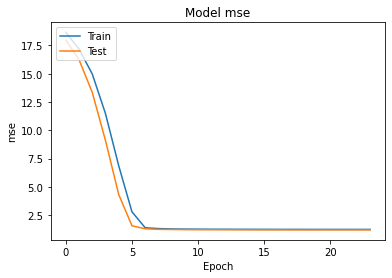

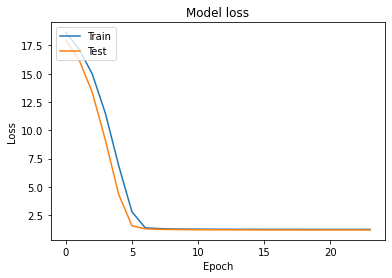

In [10]:

import matplotlib.pyplot as plt

#fig,loss_ax=plt.subplots()
#acc_ax=loss_ax.twinx()

#loss_ax.plot(hist.history["loss"],"y",label="train loss")
#loss_ax.plot(hist.history["val_loss"],"r",label="val loss")
#loss_ax.set_xlabel("epoch")
#loss_ax.set_ylabel("loss")
#loss_ax.legend(loc="upper left")

#acc_ax.plot(hist.history["accuracy"],"b",label="train acc")
#acc_ax.plot(hist.history["val_accuracy"],"g",label="val acc")
#acc_ax.set_ylabel("accuracy")
#acc_ax.legend(loc="upper left")

#plt.show()


plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('Model mse')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# loss : 훈련 손실값
# - 결과 값과의 차이를 의미하므로 작을 수록 좋고 0에 수렴할수록 좋은 모델
# acc : 훈련 정확도
# - 1에 가깝고 높을수록 좋은 모델
# val_loss : 검증 손실값
# val_acc : 검증 정확도

In [11]:
age_test = X_test[:,0:1].astype(np.float32)
dn_test = X_test[:,1:2]
cn_test = X_test[:,2:3]

# 모델 예측
result=model.predict({"Age":age_test,"ClassName":cn_test,"DivisionName":dn_test})
print(result)

[[4.310479 ]
 [4.142769 ]
 [4.1044965]
 ...
 [4.229489 ]
 [4.2101293]
 [4.1191154]]


In [3]:
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sogangori&logNo=221035995877
# http://igl-blog.com/tag/normalization/
# https://yonghyuc.wordpress.com/2020/03/04/batch-norm-vs-layer-norm/
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization
# https://dodonam.tistory.com/188